# Checking LD in window

There are a bunch of variant where despite the close vicinity, LD could not be properly resolved. THis needs to be worked out.

**Steps**:
1. Get all problematic associations (study: `GCST004860`, chromosome: `X`)
2. Read `nfe` LD index, get variant indcies for all these variants.
3. Filter the corresponding blockmatrix to get all pariwise r2
4. Plot heatmap to establish LD block.




In [1]:
import hail as hl
from hail.linalg import BlockMatrix
from pyspark.sql import SparkSession, functions as f, types as t, Column, DataFrame
from pyspark.sql.window import Window

# Initialize hail and spark:
hl.init(default_reference="GRCh38")
spark = SparkSession.builder.getOrCreate()

study_id = 'GCST004860'
chromosome = 'X'
population ='nfe'

index_file = f'gs://genetics_etl_python_playground/input/ld/gnomad_r2.1.1.{population}.common.ld.variant_indices.parquet/'
bm_file = f'gs://gcp-public-data--gnomad/release/2.1.1/ld/gnomad.genomes.r2.1.1.{population}.common.adj.ld.bm'
ld_resolved = 'gs://genetics_etl_python_playground/XX.XX/output/python_etl/parquet/pics_credible_set'



Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
Running on Apache Spark version 3.1.3
SparkUI available at http://ds-single-m.c.open-targets-eu-dev.internal:43471
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.102-817f6fb3468f
LOGGING: writing to /home/dsuveges/random_notebooks/genetics_rewrite/hail-20230113-1047-0.2.102-817f6fb3468f.log


In [6]:
# Getting problematic variants:
problematic_variants = (
    spark.read.parquet(ld_resolved)
    .filter(
        (f.col('chromosome') == chromosome) &
        (f.col('studyId') == study_id)
    )
    .select('studyId', 'variantId', 'chromosome', 'position', 'referenceAllele', 'alternateAllele', 'qualityControl')
    .distinct()
    .persist()
)

problematic_variants.show(2, False, True)

-RECORD 0-----------------------------------------------------------------------------
 studyId         | GCST004860                                                         
 variantId       | X_107158099_G_C                                                    
 chromosome      | X                                                                  
 position        | 107158099                                                          
 referenceAllele | G                                                                  
 alternateAllele | C                                                                  
 qualityControl  | [Palindrome alleles - cannot harmonize, Credible set not resolved] 
-RECORD 1-----------------------------------------------------------------------------
 studyId         | GCST004860                                                         
 variantId       | X_106545130_T_A                                                    
 chromosome      | X                       

In [19]:
matrix_indices = (
    spark.read.parquet(index_file)
    .drop('start_idx', 'stop_idx')
    .join(problematic_variants, on=['chromosome', 'position', 'referenceAllele', 'alternateAllele'], how='right')
    .withColumn(
        'new_idx', 
        f.when(
            f.col('idx').isNotNull(), 
            f.rank().over(Window.partitionBy('studyId').orderBy('idx'))
        ) - 5
    )
    .persist()
)

matrix_indices.show(truncate=False)

+----------+---------+---------------+---------------+--------+----------+---------------+----------------------------------------------------------------------------------+-------+
|chromosome|position |referenceAllele|alternateAllele|idx     |studyId   |variantId      |qualityControl                                                                    |new_idx|
+----------+---------+---------------+---------------+--------+----------+---------------+----------------------------------------------------------------------------------+-------+
|X         |107158099|G              |C              |null    |GCST004860|X_107158099_G_C|[Palindrome alleles - cannot harmonize, Credible set not resolved]                |null   |
|X         |107174072|T              |C              |null    |GCST004860|X_107174072_T_C|[Subsignificant p-value, Credible set not resolved]                               |null   |
|X         |107296299|T              |C              |null    |GCST004860|X_107296299_T_C|

In [ ]:
ndices.show(truncate=False)

At this point all the indices are in place. Now what we need to do:
1. Read blocMatrix in hl.
2. Extract values from blockmatrix based on the retrived x,y indices.
3. Collect entries. 
4. Explore ways to visualize 

In [25]:
# LD blockmatrix and indexes from gnomAD
bm = BlockMatrix.read(bm_file)
bm = bm + bm.T

# Indices of relevant rows:
indexes = [x['idx'] for x in matrix_indices.select('idx').collect() if x['idx']]

bm_sparsified = bm.filter_rows(indexes).filter_cols(indexes)
entries = bm_sparsified.entries(keyed=False)

# 
linkage = (
    entries.rename({"entry": "r"})
    .to_spark()
    .withColumn(
        "r", 
        f.when(f.col("r") >= 1, f.lit(1))
        .otherwise(f.col("r")**2)
    )
    .persist()
)

In [27]:
linkage.filter(f.col('r')!= 0).show()

+---+---+--------------------+
|  i|  j|                   r|
+---+---+--------------------+
|  0|  0|                 1.0|
|  1|  1|                 1.0|
|  1|  2|  0.2794152851446608|
|  1|  3|0.048069699070379335|
|  1|  4|  0.5639038439881825|
|  1|  5| 0.05608572555090134|
|  1|  6|0.024689428579696436|
|  1|  7| 0.04304405002627818|
|  1|  8|  0.5652444209950901|
|  1|  9|  0.1738904579531918|
|  1| 10| 0.12408263981731092|
|  1| 11|8.575456954718496E-5|
|  1| 12|6.962993366386308E-7|
|  1| 13| 0.03036372673832649|
|  1| 14|0.001198844493771...|
|  1| 15|0.012701109451930433|
|  1| 16|   0.120954067654111|
|  1| 17|  0.0723238953011779|
|  1| 18| 0.13291498329782078|
|  1| 19|   0.070482113301554|
+---+---+--------------------+
only showing top 20 rows



In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


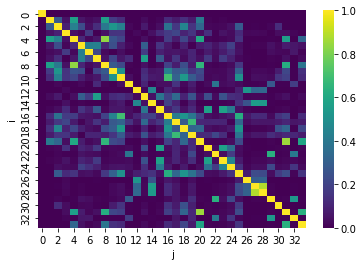

In [30]:
df = linkage.toPandas()

# pivot the dataframe from long to wide form
result = df.pivot(index='i', columns='j', values='r')

sns.heatmap(result, annot=False, fmt="g", cmap='viridis')
plt.show()

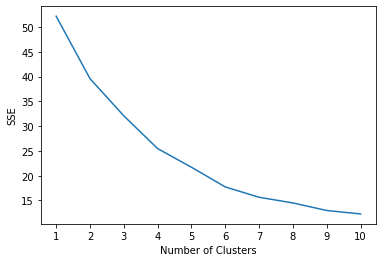

In [33]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "random_state": 1,
}

#create list to hold SSE values for each k
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(result)
    sse.append(kmeans.inertia_)

plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()


In [36]:
#instantiate the k-means class, using optimal number of clusters
kmeans = KMeans(init="random", n_clusters=5, n_init=10, random_state=1)

#fit k-means algorithm to data
kmeans.fit(result)
df['cluster'] = kmeans.labels_

ValueError: Length of values (34) does not match length of index (1156)

In [116]:
def _neglog_p(p_value_mantissa: Column, p_value_exponent: Column) -> Column:
    """Compute the negative log p-value.

    Args:
        p_value_mantissa (Column): P-value mantissa
        p_value_exponent (Column): P-value exponent

    Returns:
        Column: Negative log p-value

    Examples:
        >>> d = [(1, 1), (5, -2), (1, -1000)]
        >>> df = spark.createDataFrame(d).toDF("p_value_mantissa", "p_value_exponent")
        >>> df.withColumn("neg_log_p", _neglog_p(f.col("p_value_mantissa"), f.col("p_value_exponent"))).show()
        +----------------+----------------+------------------+
        |p_value_mantissa|p_value_exponent|         neg_log_p|
        +----------------+----------------+------------------+
        |               1|               1|              -1.0|
        |               5|              -2|1.3010299956639813|
        |               1|           -1000|            1000.0|
        +----------------+----------------+------------------+
        <BLANKLINE>
    """
    return -1 * (f.log10(p_value_mantissa) + p_value_exponent)


def adding_quality_flag(
    qc_column: Column, flag_condition: Column, flag_text: str
) -> Column:
    """Update the provided quality control list with a new flag if condition is met.

    Args:
        qc_column (Column): Array column with existing QC flags.
        flag_condition (Column): This is a column of booleans, signing which row should be flagged
        flag_text (str): Text for the new quality control flag

    Returns:
        Column: Array column with the updated list of qc flags.

    Examples:
    >>> data = [(True, ['Existing flag']),(True, []),(False, [])]
    >>> new_flag = 'This is a new flag'
    >>> (
    ...     spark.createDataFrame(data, ['flag', 'qualityControl'])
    ...     .withColumn('qualityControl', adding_quality_flag(f.col('qualityControl'), f.col('flag'), new_flag))
    ...     .show(truncate=False)
    ... )
    +-----+-----------------------------------+
    |flag |qualityControl                     |
    +-----+-----------------------------------+
    |true |[Existing flag, This is a new flag]|
    |true |[This is a new flag]               |
    |false|[]                                 |
    +-----+-----------------------------------+
    <BLANKLINE>
    """
    return f.when(
        flag_condition,
        f.array_union(qc_column, f.array(f.lit(flag_text))),
    ).otherwise(qc_column)




In [66]:
import plotly.graph_objects as go

import networkx as nx

G = nx.from_pandas_edgelist(df.query('r >= 0.5').query('i != j'),source='i', target='j', edge_attr='r')

edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

# edge_trace = go.Scatter(
#     x=edge_x, y=edge_y,
#     line=dict(width=0.5, color='#888'),
#     hoverinfo='none',
#     mode='lines')

# node_x = []
# node_y = []
# for node in G.nodes():
#     x, y = G.nodes[node]['pos']
#     node_x.append(x)
#     node_y.append(y)

# node_trace = go.Scatter(
#     x=node_x, y=node_y,
#     mode='markers',
#     hoverinfo='text',
#     marker=dict(
#         showscale=True,
#         # colorscale options
#         #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
#         #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
#         #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
#         colorscale='YlGnBu',
#         reversescale=True,
#         color=[],
#         size=10,
#         colorbar=dict(
#             thickness=15,
#             title='Node Connections',
#             xanchor='left',
#             titleside='right'
#         ),
#         line_width=2))

# node_adjacencies = []
# node_text = []
# for node, adjacencies in enumerate(G.adjacency()):
#     node_adjacencies.append(len(adjacencies[1]))
#     node_text.append('# of connections: '+str(len(adjacencies[1])))

# node_trace.marker.color = node_adjacencies
# node_trace.text = node_text

# fig = go.Figure(data=[edge_trace, node_trace],
#              layout=go.Layout(
#                 title='<br>Network graph made with Python',
#                 titlefont_size=16,
#                 showlegend=False,
#                 hovermode='closest',
#                 margin=dict(b=20,l=5,r=5,t=40),
#                 annotations=[ dict(
#                     text="Python code: <a href='https://plotly.com/ipython-notebooks/network-graphs/'> https://plotly.com/ipython-notebooks/network-graphs/</a>",
#                     showarrow=False,
#                     xref="paper", yref="paper",
#                     x=0.005, y=-0.002 ) ],
#                 xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
#                 yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
#                 )
# fig.show()

KeyError: 'pos'

In [45]:
%load_ext rpy2.ipython

In [87]:
G = nx.random_geometric_graph(200, 0.125)
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = G.nodes[edge[0]]['pos']
    x1, y1 = G.nodes[edge[1]]['pos']
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

G.nodes[55]

{'pos': [0.6286908122731053, 0.27867150805583674]}

In [77]:
G.nodes(55)['pos']

KeyError: 'pos'

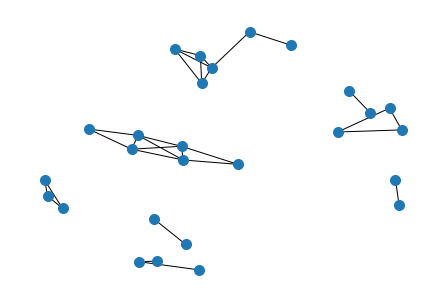

In [112]:
G = nx.from_pandas_edgelist(df.query('r >= 0.5').query('i != j'),source='i', target='j', edge_attr='r')
nx.draw(G, pos = nx.spring_layout(G, k=1, iterations=100, scale=None),  node_size=100)

In [149]:
column_names = [
    'studyId',
    'variantId',
    'tagVariantId',
    'pValueMantissa',
    'pValueExponent',
    'R_overall',
]

data = [
    # First study, variant 1 independent association:
    ('s1', 'v1', 'v1', 1, -9, 1.0),
    # First study, variant 3, not resolved in ld:
    ('s1', 'v2', None, 1, -18, None),
    # First study, variant 2, higher p-value, explained by v1:
    ('s1', 'v3', 'v4', 1, -18, 1.0),
    ('s1', 'v3', 'v5', 1, -18, 0.98),
    # First study, variant 4: higher p-value, explained by v1
    ('s1', 'v4', 'v3', 4, -9, 0.98),
    ('s1', 'v4', 'v5', 4, -9, 0.98),
    ('s1', 'v4', 'v6', 4, -9, 1.0),
    # Second study, same variant discovered earlier:
    ('s1', 'v5', 'v3', 1, -8, 1.0),
    ('s1', 'v5', 'v4', 1, -8, 0.98),
    ('s1', 'v5', 'v6', 1, -8, 0.98),
    # Second study, same variant discovered earlier:
    ('s1', 'v6', 'v5', 5, -8, 1.0),
    ('s1', 'v6', 'v4', 5, -8, 1.0),
    ('s1', 'v6', 'v7', 5, -8, 1.0),
    # Second study, same variant discovered earlier:
    ('s1', 'v7', 'v6', 1, -18, 1.0),
]

df = (
    spark.createDataFrame(data, column_names)
    .withColumn('qualityControl', f.array())
    .persist()
)
df.show()

+-------+---------+------------+--------------+--------------+---------+--------------+
|studyId|variantId|tagVariantId|pValueMantissa|pValueExponent|R_overall|qualityControl|
+-------+---------+------------+--------------+--------------+---------+--------------+
|     s1|       v1|          v1|             1|            -9|      1.0|            []|
|     s1|       v2|        null|             1|           -18|     null|            []|
|     s1|       v3|          v4|             1|           -18|      1.0|            []|
|     s1|       v3|          v5|             1|           -18|     0.98|            []|
|     s1|       v4|          v3|             4|            -9|     0.98|            []|
|     s1|       v4|          v5|             4|            -9|     0.98|            []|
|     s1|       v4|          v6|             4|            -9|      1.0|            []|
|     s1|       v5|          v3|             1|            -8|      1.0|            []|
|     s1|       v5|          v4|

In [194]:
def get_resolver(df):

    return (
        df
        .select(
            'studyId', 
            f.col('variantId').alias('explained'),
            f.col('explained').alias('new_explained')
        )
        .distinct()
    )

def clean_dataframe(df):
    if 'is_resolved' in df.columns:
        return (
            df
            .drop('explained', 'is_resolved')
            .withColumnRenamed('new_explained', 'explained')
        )
    else:
        return df


def _clumping(df: DataFrame) -> DataFrame:
    """Clump non-independent credible sets.

    Args:
        df (DataFrame): The LD expanded dataset, before PICS calculation

    Returns:
        DataFrame: Clumped signals are resolved by:
        - removing tagging varinants of non independent leads.
        - removing overall R from non independent leads.
        - Adding QC flag to non-independent leads pointing to the relevant lead.
    """
    w = Window.partitionBy("studyId", "variantPair").orderBy(f.col("negLogPVal").desc())

    # This dataframe contains all the resolved and independent leads. However not all linked signals are properly assigned to a more significant lead:
    resolved_independent = (
        df
        # lead/tag pairs irrespective of the order:
        .withColumn(
            "variantPair",
            f.concat_ws('_', f.array_sort(f.array(f.col("variantId"), f.col("tagVariantId")))),
        )
        # Generating the negLogPval:
        .withColumn(
            "negLogPVal", _neglog_p(f.col("pValueMantissa"), f.col("pValueExponent"))
        )
        # Counting the number of occurrence for each pair - for one study, each pair should occure only once:
        .withColumn("rank", f.count(f.col("tagVariantId")).over(w))
        # Only the most significant lead is kept if credible sets are overlapping + keeping lead if credible set is not resolved:
        .withColumn(
            "keep_lead",
            f.when(
                f.max(f.col("rank")).over(Window.partitionBy("studyId", "variantId")) <= 1, True,
            ).otherwise(False),
        )
        # Adding reference lead that explains:
        .withColumn(
            "reference_lead", 
            f.when(
                f.col("rank") > 1, 
                f.col("tagVariantId")
            ).when(
                f.col('keep_lead'),
                f.col('variantId')
            )
        )
        # One credible set might contain multiple tags that are themselves leads. We need to collect them into an array:
        # At this point we move from lead/tag to study/lead level:
        .withColumn(
            "all_explained",
            f.collect_set(f.col("reference_lead")).over(
                Window.partitionBy("studyId", "variantId")
            ),
        )
        .withColumn('explained', f.explode('all_explained'))
        .drop('reference_lead', "all_explained")
        .persist()
    )

    # We need to keep iterating until all linked leads are resolved:
    while True:
        resolved_independent = (
            resolved_independent
            .transform(clean_dataframe)
            .join(get_resolver(resolved_independent), on=['studyId', 'explained'], how='left')
            .withColumn(
                'is_resolved',
                f.when(f.col('new_explained') == f.col('explained'), True).otherwise(False)
            )
            .persist()
        )

        if resolved_independent.select('is_resolved').distinct().count() == 1:
            break

    # At this point all linked leads are resolved. Now the dataframe needs to be consolidated:
    return (
        resolved_independent
        .drop('is_resolved', 'new_explained', 'neglog_pval')
        .withColumn(
            'qualityControl',
            adding_quality_flag(
                f.col("qualityControl"),
                ~f.col('keep_lead'),
                f.concat_ws(' ', f.lit('Association explained by:'), f.concat_ws(', ', f.collect_set(f.col('explained')).over(Window.partitionBy('studyId', 'variantId'))))
            )
        )
        # Remove tag information if lead is explained by other variant:
        .withColumn(
            "tagVariantId",
            f.when(f.col("explained") == f.col('variantId'), f.col("tagVariantId")),
        )
        .withColumn(
            "R_overall", f.when(f.col("tagVariantId").isNotNull(), f.col("R_overall"))
        )
        # Drop unused column:
        .drop(
            "variantPair",
            "explained",
            "negLogPVal",
            "rank",
            "keep_lead",
        )
        .distinct()
        .orderBy('studyId', 'variantId')
    )


(
    df
    .transform(_clumping)
    .show(truncate=False)
)

+-------+---------+------------+--------------+--------------+---------+----------------------------------+
|studyId|variantId|tagVariantId|pValueMantissa|pValueExponent|R_overall|qualityControl                    |
+-------+---------+------------+--------------+--------------+---------+----------------------------------+
|s1     |v1       |v1          |1             |-9            |1.0      |[]                                |
|s1     |v2       |null        |1             |-18           |null     |[]                                |
|s1     |v3       |v5          |1             |-18           |0.98     |[]                                |
|s1     |v3       |v4          |1             |-18           |1.0      |[]                                |
|s1     |v4       |null        |4             |-9            |null     |[Association explained by: v3]    |
|s1     |v5       |null        |1             |-8            |null     |[Association explained by: v3]    |
|s1     |v6       |null     

In [173]:

resolved_independent = (
    df
    # lead/tag pairs irrespective of the order:
    .withColumn(
        "variantPair",
        f.concat_ws('_', f.array_sort(f.array(f.col("variantId"), f.col("tagVariantId")))),
    )
    # Generating the negLogPval:
    .withColumn(
        "negLogPVal", _neglog_p(f.col("pValueMantissa"), f.col("pValueExponent"))
    )
    # Counting the number of occurrence for each pair - for one study, each pair should occure only once:
    .withColumn("rank", f.count(f.col("tagVariantId")).over(w))
    # Only the most significant lead is kept if credible sets are overlapping + keeping lead if credible set is not resolved:
    .withColumn(
        "keep_lead",
        f.when(
            f.max(f.col("rank")).over(Window.partitionBy("studyId", "variantId"))
            <= 1,
            True,
        ).otherwise(False),
    )
    # Adding reference lead that explains:
    .withColumn(
        "reference_lead", 
        f.when(
            f.col("rank") > 1, 
            f.col("tagVariantId")
        ).when(
            f.col('keep_lead'),
            f.col('variantId')
        )
    )
    # One credible set might contain multiple tags that are themselves leads. We need to collect them into an array:
    # At this point we move from lead/tag to study/lead level:
    .withColumn(
        "all_explained",
        f.collect_set(f.col("reference_lead")).over(
            Window.partitionBy("studyId", "variantId")
        ),
    )
    # .withColumn('explained', f.explode('all_explained'))
    # .drop('reference_lead', "all_explained")
    # # For a study we collect all the lead variants that are not explained by other lead:
    # .withColumn(
    #     "good_signals",
    #     f.collect_set(f.when(f.col("keep_lead"), f.col("variantId"))).over(
    #         Window.partitionBy("studyId")
    #     ),
    # )
    .persist()
)


columns = ['variantId', 'tagVariantId', 'all_explained']
resolved_independent.select(columns).orderBy('variantId').show(100)

+---------+------------+-------------+
|variantId|tagVariantId|all_explained|
+---------+------------+-------------+
|       v1|          v1|         [v1]|
|       v2|        null|         [v2]|
|       v3|          v5|         [v3]|
|       v3|          v4|         [v3]|
|       v4|          v3|         [v3]|
|       v4|          v5|         [v3]|
|       v4|          v6|         [v3]|
|       v5|          v4|     [v4, v3]|
|       v5|          v3|     [v4, v3]|
|       v5|          v6|     [v4, v3]|
|       v6|          v7| [v4, v5, v7]|
|       v6|          v5| [v4, v5, v7]|
|       v6|          v4| [v4, v5, v7]|
|       v7|          v6|         [v7]|
+---------+------------+-------------+



In [171]:
def get_resolver(df):

    return (
        df
        .select(
            'studyId', 
            f.col('variantId').alias('explained'),
            f.col('explained').alias('new_explained')
        )
        .distinct()
    )

def clean_dataframe(df):
    if 'is_resolved' in df.columns:
        return (
            df
            .drop('explained', 'is_resolved')
            .withColumnRenamed('new_explained', 'explained')
        )
    else:
        return df

one_step = (
    resolved_independent
    .transform(clean_dataframe)
    .join(get_resolver(resolved_independent), on=['studyId', 'explained'], how='left')
    .withColumn(
        'is_resolved',
        f.when(f.col('new_explained') == f.col('explained'), True).otherwise(False)
    )
    .persist()
)

one_step.select(columns + ['new_explained', 'is_resolved']).show(100)

two_step = (
    one_step
    .transform(clean_dataframe)
    .join(get_resolver(one_step), on=['studyId', 'explained'], how='left')
    .withColumn(
        'is_resolved',
        f.when(f.col('new_explained') == f.col('explained'), True).otherwise(False)
    )
    .persist()
)

two_step.select(columns + ['new_explained', 'is_resolved']).show(100)

three_step = (
    two_step
    .transform(clean_dataframe)
    .join(get_resolver(one_step), on=['studyId', 'explained'], how='left')
    .withColumn(
        'is_resolved',
        f.when(f.col('new_explained') == f.col('explained'), True).otherwise(False)
    )
    .persist()
)

three_step.select(columns + ['new_explained', 'is_resolved']).show(100)

+---------+------------+---------+-------------+-----------+
|variantId|tagVariantId|explained|new_explained|is_resolved|
+---------+------------+---------+-------------+-----------+
|       v7|          v6|       v7|           v7|       true|
|       v2|        null|       v2|           v2|       true|
|       v4|          v5|       v3|           v3|       true|
|       v4|          v6|       v3|           v3|       true|
|       v4|          v3|       v3|           v3|       true|
|       v3|          v4|       v3|           v3|       true|
|       v3|          v5|       v3|           v3|       true|
|       v6|          v4|       v4|           v3|      false|
|       v6|          v4|       v5|           v3|      false|
|       v6|          v4|       v5|           v4|      false|
|       v6|          v4|       v7|           v7|       true|
|       v6|          v7|       v4|           v3|      false|
|       v6|          v7|       v5|           v3|      false|
|       v6|          v7|

+---------+------------+---------+-------------+-----------+
|variantId|tagVariantId|explained|new_explained|is_resolved|
+---------+------------+---------+-------------+-----------+
|       v7|          v6|       v7|           v7|       true|
|       v2|        null|       v2|           v2|       true|
|       v4|          v5|       v3|           v3|       true|
|       v4|          v6|       v3|           v3|       true|
|       v4|          v3|       v3|           v3|       true|
|       v3|          v4|       v3|           v3|       true|
|       v3|          v5|       v3|           v3|       true|
|       v6|          v4|       v3|           v3|       true|
|       v6|          v4|       v3|           v3|       true|
|       v6|          v4|       v3|           v3|       true|
|       v6|          v4|       v7|           v7|       true|
|       v6|          v7|       v3|           v3|       true|
|       v6|          v7|       v3|           v3|       true|
|       v6|          v7|

In [188]:
(
    three_step
    .drop('is_resolved', 'new_explained', 'neglog_pval')
    .withColumn(
        'qualityControl',
        adding_quality_flag(
            f.col("qualityControl"),
            ~f.col('keep_lead'),
            f.concat_ws(' ', f.lit('Association explained by:'), f.concat_ws(', ', f.collect_set(f.col('explained')).over(Window.partitionBy('studyId', 'variantId'))))
        )
    )
    # Remove tag information if lead is explained by other variant:
    .withColumn(
        "tagVariantId",
        f.when(f.col("explained") == f.col('variantId'), f.col("tagVariantId")),
    )
    .withColumn(
        "R_overall", f.when(f.col("tagVariantId").isNotNull(), f.col("R_overall"))
    )
    # Drop unused column:
    .drop(
        "variantPair",
        "explained",
        "negLogPVal",
        "rank",
        "keep_lead",
    )
    .distinct()
    .orderBy('variantId')
    .show(truncate=False)
)

+-------+---------+------------+--------------+--------------+---------+----------------------------------+
|studyId|variantId|tagVariantId|pValueMantissa|pValueExponent|R_overall|qualityControl                    |
+-------+---------+------------+--------------+--------------+---------+----------------------------------+
|s1     |v1       |v1          |1             |-9            |1.0      |[]                                |
|s1     |v2       |null        |1             |-18           |null     |[]                                |
|s1     |v3       |v5          |1             |-18           |0.98     |[]                                |
|s1     |v3       |v4          |1             |-18           |1.0      |[]                                |
|s1     |v4       |null        |4             |-9            |null     |[Association explained by: v3]    |
|s1     |v5       |null        |1             |-8            |null     |[Association explained by: v3]    |
|s1     |v6       |null     

In [193]:
two_step.select('is_resolved').distinct().count()

2